In [1]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt
from operator import itemgetter
import itertools

In [2]:
#Create class to handle "cities"
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"
        #return  str(self.x) + "," + str(self.y)
    
    def __iter__(self):
        yield self.x
        yield self.y

   

In [3]:
#Create a fitness function
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                #fromCity=City(0.3642, 0.7770)
                #toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                #else:
                    #toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

In [4]:
#Route generator
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route

In [5]:
#Create first "population" (list of routes)
def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

In [6]:
#Rank individuals
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

In [7]:
#Create a selection function that will be used to make the list of parent routes
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

In [8]:
#Create mating pool
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

In [9]:
#Create a crossover function for two parents to create one child
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

In [10]:
#Create function to run crossover over full mating pool
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

In [11]:
#Create function to mutate a single route
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            swapWith2 = int(random.random() * len(individual))
            
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            
            individual[swapped] = city2
            individual[swapWith] = city1
            
    return individual

In [12]:
#Create function to run mutation over entire population
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

In [13]:
#all steps together to create the next generation
def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

In [14]:
#Final step: create the genetic algorithm
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
    
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    
    
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    
    #defining the start and end city. So the start city will always be the value in index 6 and end city will be at index 7
    startCity = bestRoute[6]
    endCity = bestRoute[7]
    
    #simply appending the starting and ending city in-order
    bestRoute.remove(startCity)
    bestRoute.remove(endCity)
    
    bestRoute.insert(0,startCity)
    bestRoute.insert(len(bestRoute),endCity)
    
    
    #plotting
    plt.scatter(*zip(*bestRoute))
    plt.plot(*zip(*bestRoute))
    plt.show()
    return bestRoute

## Running the genetic algorithm

Create list of cities

In [15]:
cityList = []

#for i in range(0,25):
    #cityList.append(City(x=int(random.random() * 200), y=int(random.random() * 200)))


cityList.append(City(0.3642, 0.7770))
cityList.append(City(0.7185, 0.8312))
cityList.append(City(0.0986, 0.5891))
cityList.append(City(0.2954, 0.9606))
cityList.append(City(0.5951, 0.4647))
cityList.append(City(0.6697, 0.7657))
cityList.append(City(0.4353, 0.1709))
cityList.append(City(0.2131, 0.8349))
cityList.append(City(0.3479, 0.6984))
cityList.append(City(0.4516, 0.0488))


Run the genetic algorithm

Initial distance: 2.8198797729459177
Final distance: 1.94083775936972


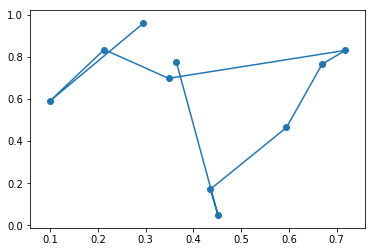

[(0.3642,0.777),
 (0.4516,0.0488),
 (0.4353,0.1709),
 (0.5951,0.4647),
 (0.6697,0.7657),
 (0.7185,0.8312),
 (0.3479,0.6984),
 (0.2131,0.8349),
 (0.0986,0.5891),
 (0.2954,0.9606)]

In [16]:

geneticAlgorithm(population=cityList, popSize=40, eliteSize=10, mutationRate=0.0001, generations=100)


In [17]:
#separate GA for plotting progress
def geneticAlgorithmPlot(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
    
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    
    plt.show()

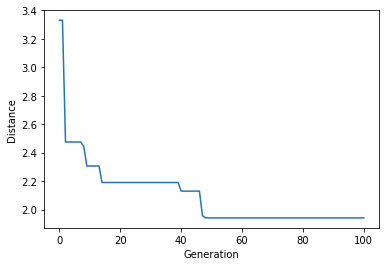

In [18]:
geneticAlgorithmPlot(population=cityList, popSize=40, eliteSize=10, mutationRate=0.0001, generations=100)